In [1]:
import pandas as pd
from resource_consolidation import Resources, Trip, dayint_to_daystr

In [2]:
url = 'https://data.wprdc.org/dataset/healthyride-trip-data'
resource_extension = '/dataset/healthyride-trip-data/resource/'
resource_calling_string = 'https://data.wprdc.org/api/3/action/datastore_search?resource_id='


In [3]:
#create empty container for data 
data_container = Resources(url, resource_extension, resource_calling_string)
#create json string with data from API
json_list = data_container.create_json()

working on: https://data.wprdc.org/api/3/action/datastore_search?resource_id=102b0be5-aa3f-48b5-9306-e628ae1ae44d
of length: 7224
correct length
working on: https://data.wprdc.org/api/3/action/datastore_search?resource_id=c85436af-ba38-4d91-967f-3e11e4d62a43
of length: 500000
correct length
working on: https://data.wprdc.org/api/3/action/datastore_search?resource_id=7c5a30a3-797d-4861-b979-6bb4298b7d0d
of length: 27706
correct length
working on: https://data.wprdc.org/api/3/action/datastore_search?resource_id=7fe58023-39be-4fa5-a7b7-27d7b0e077a7
of length: 15100
correct length
working on: https://data.wprdc.org/api/3/action/datastore_search?resource_id=79fc7302-7991-4b5a-b27a-d7c4f21b5b8d
of length: 12225
correct length
working on: https://data.wprdc.org/api/3/action/datastore_search?resource_id=e71c0d16-0109-4b50-9ea2-02d82180b7e7
of length: 43616
correct length
working on: https://data.wprdc.org/api/3/action/datastore_search?resource_id=fe985614-775c-42e3-9647-59099806329d
of length:

In [4]:
print(json_list[0])


{'Trip id': '25723960', 'Bikeid': '70478', 'To station name': 'Zulema St & Coltart Ave', 'Usertype': 'Subscriber', 'Stoptime': '1/1/2017 8:30', 'From station name': 'S Millvale Ave & Centre Ave', 'Starttime': '1/1/2017 8:28', 'To station id': '1044', 'Tripduration': '110', '_id': 1, 'From station id': '1043'}


In [5]:
#convert list of dicts to list of objects called "Trips"
Trip_list = []
for dict in json_list:
    li = list(dict.values())
    Trip_list.append(Trip(*li))

In [6]:
#test er out
print(Trip_list[420])
print(Trip_list[420].toname)
print(Trip_list[420].starttime)
print(Trip_list[420].weekday)

S Euclid Ave & Centre Ave
1/14/2017 11:58
5


In [7]:
def sort_by_stations(station_ids, Trip_list):
    master_to = []
    master_from = []
    for station in station_ids:
        master_to += [i for i in Trip_list if i.toid == station]
        master_from += [i for i in Trip_list if i.fromid == station]
    return master_to, master_from



pnc_station_ids = ['49941','49921', '1012']

downtown_station_ids = ['1000', '49701', '1002', '1001', '49691', '49671', '1056', '1003', '49731', '1004', '1006', '49651', '1010']

station_trip_list_to = sort_by_stations(downtown_station_ids, Trip_list)[0]
station_trip_list_from = sort_by_stations(downtown_station_ids, Trip_list)[1]

print(len(station_trip_list_to))
print(len(station_trip_list_from))


109895
105817


In [8]:
class Weekday:
    def __init__(self, weekday, arrivals = [], departures = []):
        self.weekday = weekday
        self.arrivals = arrivals
        self.departures = departures


In [9]:
def weekday_arrivals_todict(list_of_trip_objects):
    weekday_dict = {}
    for trip in list_of_trip_objects:
        this_weekday = trip.weekday
        if this_weekday not in list(weekday_dict.keys()):
            weekday_dict[this_weekday] = [trip.starttime.split(" ")[1]]
        else:
            weekday_dict[this_weekday].append(trip.starttime.split(" ")[1])
    return weekday_dict

def weekday_departures_todict(list_of_trip_objects):
    weekday_dict = {}
    for trip in list_of_trip_objects:
        this_weekday = trip.weekday
        if this_weekday not in list(weekday_dict.keys()):
            weekday_dict[this_weekday] = [trip.stoptime.split(" ")[1]]
        else:
            weekday_dict[this_weekday].append(trip.stoptime.split(" ")[1])
    return weekday_dict



In [10]:
#for use with weekday object
to_dict = weekday_arrivals_todict(station_trip_list_to)
from_dict = weekday_departures_todict(station_trip_list_from)

In [11]:
print(to_dict.keys())

dict_keys([6, 0, 2, 3, 4, 1, 5])


In [12]:
to_dates = list(to_dict.keys())
from_dates = list(from_dict.keys())

unique_to_arrivals = [i for i in to_dates if i not in from_dates]
unique_to_departures = [i for i in from_dates if i not in to_dates]

shared_dates = [i for i in to_dates if i not in unique_to_arrivals]
print(shared_dates)

[6, 0, 2, 3, 4, 1, 5]


In [13]:
#for use of weekday object list
weekday_object_list = []

for i in shared_dates:
    weekday_object_list.append(Weekday(i, to_dict[i], from_dict[i]))


In [14]:
#double check which object list you're using

search_index = shared_dates.index(5)

print(weekday_object_list[search_index].weekday)
print(weekday_object_list[search_index].arrivals[:10])
print(weekday_object_list[search_index].departures[:10])

5
['10:05', '10:05', '12:16', '12:25', '12:27', '13:24', '13:24', '14:27', '14:33', '14:51']
['13:41', '13:17', '14:24', '14:22', '14:26', '14:26', '15:06', '15:49', '15:50', '15:48']


In [15]:
import matplotlib.pylab as plt
from collections import Counter

def plot_hourly_volume(da, dd):
    listsa = sorted(da.items()) # sorted by key, return a list of tuples
    xa, ya = zip(*listsa) # unpack a list of pairs into two tuples

    listsd = sorted(dd.items()) # sorted by key, return a list of tuples
    xd, yd = zip(*listsd)
    
    plt.plot(xa, ya, "g-")
    plt.plot(xd, yd, 'r-')

    plt.show()

def hourly_volume(li):
    hourly_list = sorted([int(i.split(':')[0]) for i in li])
    counted_vals = Counter(hourly_list)
    return counted_vals


def plot_days_of_wk(weekday_object_list):
    weekday_object_list.sort(key=lambda x: x.weekday, reverse=True)
    for i, val in enumerate(weekday_object_list):
        arrivals_volume = hourly_volume(weekday_object_list[val.weekday].arrivals)
        print(i)
        departures_volume = hourly_volume(weekday_object_list[val.weekday].departures)
        print(dayint_to_daystr(i))
        plot_hourly_volume(arrivals_volume, departures_volume)

0
Monday


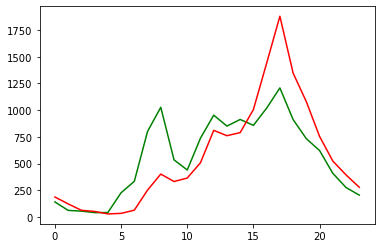

1
Tuesday


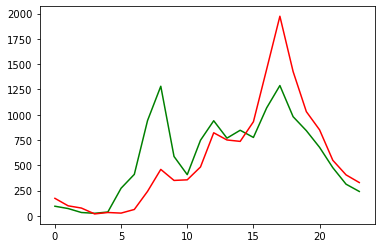

2
Wednesday


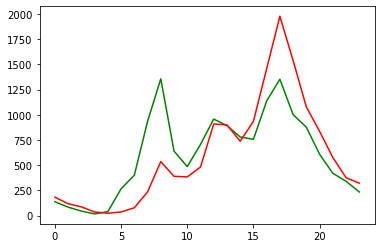

3
Thursday


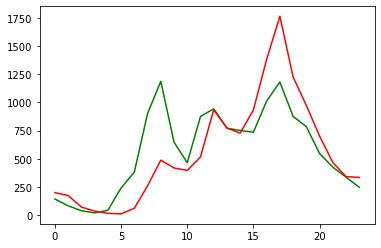

4
Friday


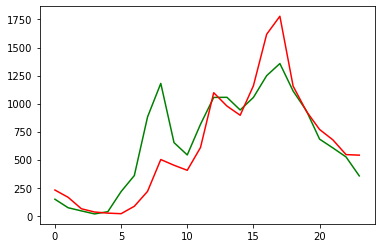

5
Saturday


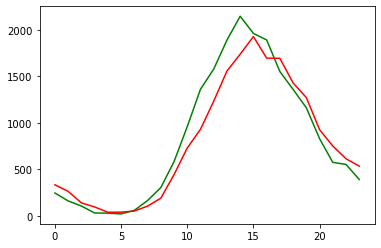

6
Sunday


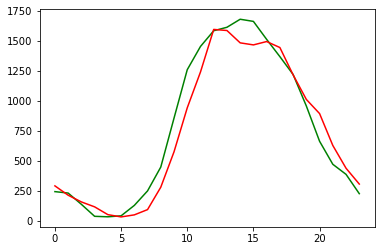

In [16]:
plot_days_of_wk(weekday_object_list)


